<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Solutions_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions to Part 2.

In [ ]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [ ]:
pip install umap-learn

In [ ]:
import umap

In [ ]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    !tar -xvzf colab_material.tgz > /dev/null 2>&1

In [ ]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [ ]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))
  
  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

In [ ]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')

In [ ]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [ ]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)
  
  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)
  
  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()                              
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [ ]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)
    
    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)
    
    return features_scaled

In [ ]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

In [ ]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');

## 3. Blobs

In [ ]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)


## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

In [ ]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout(0,0,0)

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

# EXERCISE 0 (bonus) : PCA with a non-linear data-set

In [ ]:
# 1. Load the data using the function load_ex1_data_pca() , check the dimensionality of the data and plot them.
# Solution:

data = load_ex1_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca.fit(data)

# 3. Check the explained variance ratio and select best number of components.

print('Explained variance ratio: ' ,pca.explained_variance_ratio_)

# 4. Plot the reconstructed vectors for different values of k.

scores=pca.transform(data)
for k in range(1,3):
    res=np.dot(scores[:,:k], pca.components_[:k,:]) 

    plt.figure(figsize=((5,5)))
    plt.title('Reconstructed vector for k ='+ str(k))
    plt.plot(res[:,0],res[:,1],'o')
    plt.plot(data[:,0],data[:,1],'o')

    for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
        plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

    plt.grid()
    
# Message: if the manyfold is non-linear one is forced to use a high number of principal components. 
# For example, in the parabola example the projection for k=1 looks bad. But using too many principal components 
# the reconstructed vectors are almost equal to the original ones (for k=2 we get exact reconstruction in our example ) 
# and the advanteges of dimensionality reduction are lost. This is a general pattern.

# EXERCISE 1 (option 1): Pressure response from body movements

In [ ]:
high_dim_dataset=load_multidimensional_data_pca(n_data=40 ,n_vec=6, dim=20, eps= 0.5)
n_samples,n_dim=high_dim_dataset.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

pca=PCA()
pca.fit(high_dim_dataset)
plt.plot([str(i) for i in range(1,len(pca.explained_variance_ratio_)+1)],
         pca.explained_variance_ratio_,'-o')
plt.title('Scree plot')
plt.ylabel('Percentage of explained variance')
plt.grid()
plt.show()

In [ ]:
for vec in pca.components_[:6]:
    plt.figure()
    plt.plot([f'sensor {i}' for i in range(1,len(pca.explained_variance_ratio_)+1)], vec)
    plt.xticks(rotation=90)
    plt.grid()

# EXERCISE 2 (option 2): PCA on a single image

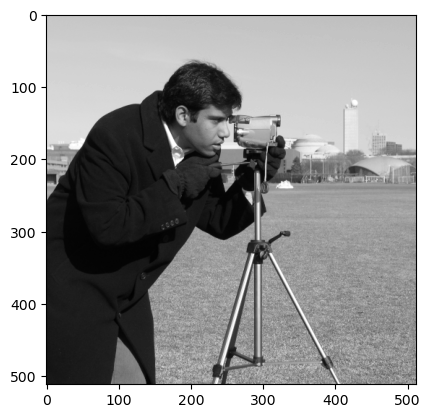

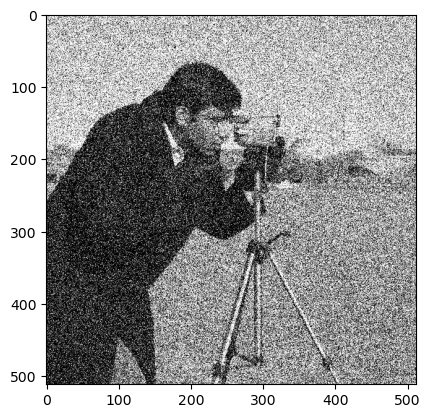

In [5]:
from skimage import data, img_as_float
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

image = img_as_float(data.camera()) 
noisy_image = random_noise(image, mode='gaussian', var=0.1)
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(noisy_image, cmap='gray')

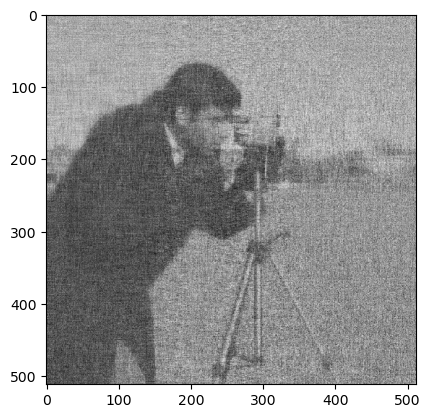

In [8]:
pca=PCA(n_components=64)
pca.fit(noisy_image)
scores=pca.transform(noisy_image)
reconstructed_image = pca.inverse_transform(scores)
plt.imshow(reconstructed_image, cmap='gray')

# EXERCISE 2 : Find the hidden drawing.

In [ ]:
# 1. Load the data using the function load_ex2_data_pca(seed=1235) , check the dimensionality of the data and plot them.

data= load_ex2_data_pca(seed=1235)
n_samples,n_dim=data.shape
print('We have ',n_samples, 'samples of dimension ', n_dim)

# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca.fit(data)

# 3. Check the explained variance ratio and select best number of components.
plt.figure()
print('Explained variance ratio: ' ,pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_,'-o')
plt.xlabel('k')
plt.ylabel('Explained variance ratio')
plt.grid()

# 4. Can you make a 2D plots that visualized the first two scores of the dataset ?.
plt.figure()
k=2
data_transformed=pca.transform(data)
plt.plot(data_transformed[:,0],data_transformed[:,1],'o')

# **Message:** Sometimes the data hides simple patterns in high dimensional datasets. 
# PCA can be very useful in identifying these patterns.